<a href="https://colab.research.google.com/github/aryan-anil/Stable-Diffusion/blob/main/sd/stable_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import math
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

# **Attention**

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):  # d_embed = channels
    super().__init__()
    self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias) # Wq, Wk and Wv matrices into 1, returns q, k, v combined
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias) # Wout matrix
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads

  def forward(self, x, causal_mask=False):
    # x: (batch, seq_len, dim),   dim: height * width
    input_shape = x.shape

    batch_size, seq_length, d_embed = input_shape

    intermediate_shape = (batch_size, seq_length, self.n_heads, self.d_head)      # (batch, seq_len, dim) -> (batch, seq_len, n_heads, dim/n_heads)

    q, k, v = self.in_proj(x).chunk(3, dim=-1)          # (batch, seq_len, dim) -> (batch, seq_len, 3 * dim) -> 3 tensors of (batch, seq_len, dim)
                                                        # combines 3 in_ projections Wq, Wk, Wv into 1,  splits last dim  to make q, k, v

    q = q.view(intermediate_shape).transpose(1, 2)  # (batch, seq_len, dim) -> (batch, seq_len, n_heads, dim/n_heads) -> (batch, n_heads, seq_len, dim/n_heads)
    k = k.view(intermediate_shape).transpose(1, 2)
    v = v.view(intermediate_shape).transpose(1, 2)

    weight = q @ k.transpose(-1, -2) # (batch, n_heads, seq_len, dim/n_head) * (batch, n_heads, dim/n_heads, seq_len)  -> (batch, n_heads, seq_len, seq_len)

    if causal_mask:
      mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
      weight.masked_fill_(mask, -torch.inf)

    weight /= math.sqrt(self.d_head)         # (batch, n_heads, seq_len, seq_len)
    weight = F.softmax(weight, dim=-1)

    output = weight @ v  # (batch, n_heads, seq_len, seq_len) * (batch, n_heads, seq_len, dim/n_heads) -> (batch, n_heads, seq_len, dim/n_heads)

    output = output.transpose(1, 2)      # (batch, seq_len, n_heads, dim/n_heads)
    output = output.reshape(input_shape) # (batch, seq_len, dim)
    output = self.out_proj(output)       # (batch, seq_len, dim)

    return output

class CrossAttention(nn.Module):
  def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
    self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
    self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
    self.n_heads = n_heads
    self.d_head = d_embed // n_heads

  def forward(self, x, y):
    # x (latent, query): (batch_size, seq_len_Q, dim_Q)
    # y (context, KV): (batch_size, seq_len_KV, dim_KV) = (batch_size, 77, 768)  prompt size: 77 embedded in 768 dim

    input_shape = x.shape
    batch_size, sequence_length, d_embed = input_shape
    # Divide each embedding of Q into multiple heads such that d_heads * n_heads = dim_Q
    interim_shape = (batch_size, -1, self.n_heads, self.d_head)

    # (batch_size, seq_len_Q, dim_Q) -> (batch_size, seq_len_Q, dim_Q)
    q = self.q_proj(x)
    # (batch_size, seq_len_KV, dim_KV) -> (batch_size, seq_len_KV, dim_Q)
    k = self.k_proj(y)
    # (batch_size, seq_len_KV, dim_KV) -> (batch_size, seq_len_KV, dim_Q)
    v = self.v_proj(y)

    # (batch_size, seq_len_Q, dim_Q) -> (batch_size, seq_len_Q, H, dim_Q / H) -> (batch_size, H, seq_len_Q, dim_Q / H)
    q = q.view(interim_shape).transpose(1, 2)
    # (batch_size, seq_len_KV, dim_Q) -> (batch_size, seq_len_KV, H, dim_Q / H) -> (batch_size, H, seq_len_KV, dim_Q / H)
    k = k.view(interim_shape).transpose(1, 2)
    # (batch_size, seq_len_KV, dim_Q) -> (batch_size, seq_len_KV, H, dim_Q / H) -> (batch_size, H, seq_len_KV, dim_Q / H)
    v = v.view(interim_shape).transpose(1, 2)

    # (batch_size, H, seq_len_Q, dim_Q / H) * (batch_size, H, dim_Q / H, seq_len_KV) -> (batch_size, H, seq_len_Q, seq_len_KV)
    weight = q @ k.transpose(-1, -2)

    # (batch_size, H, seq_len_Q, seq_len_KV)
    weight /= math.sqrt(self.d_head)

    # (batch_size, H, seq_len_Q, seq_len_KV)
    weight = F.softmax(weight, dim=-1)

    # (batch_size, H, seq_len_Q, seq_len_KV) * (batch_size, H, seq_len_KV, dim_Q / H) -> (batch_size, H, seq_len_Q, dim_Q / H)
    output = weight @ v

    # (batch_size, H, seq_len_Q, dim_Q / H) -> (batch_size, seq_len_Q, H, dim_Q / H)
    output = output.transpose(1, 2).contiguous()

    # (batch_size, seq_len_Q, H, dim_Q / H) -> (batch_size, seq_len_Q, dim_Q)
    output = output.view(input_shape)

    # (batch_size, seq_len_Q, dim_Q) -> (batch_size, seq_len_Q, dim_Q)
    output = self.out_proj(output)

    # (batch_size, seq_len_Q, dim_Q)
    return output

# **VAE Decoder**

In [ ]:

class VAE_AttentionBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.attention = SelfAttention(1, in_channels)

  def forward(self, x):
    # x: (batch, feature, height, width)

    x_input = x
    n, c, h, w = x.shape
    x = x.reshape(n, c, h * w)   # (batch, feature, height, width) -> (batch, feature, height * width)
    x = x.transpose(-1, -2)      # (batch, feature, height * width) -> (batch, height * width, feature)
    x = self.attention(x)
    x = x.transpose(-1, -2)      # (batch, height * width, feature) -> (batch, feature, height * width)
    x = x.view((n, c, h, w))     # (batch, feature, height * width) -> (batch, feature, height, width)

    x = x + x_input
    return x


class VAE_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm_1 = nn.GroupNorm(32, in_channels)
    self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm_2 = nn.GroupNorm(32, out_channels)
    self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    # no change in dim

    # Add tensors if out_channels == in_channels , else transform in_channels dim of input 'x' to to out_channels,  y = F(x, W) + x
    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # x: (batch, in_channels, Height, Width)
    x_input = x  # save x

    x = self.groupnorm_1(x)
    x = F.silu(x)
    x = self.conv_1(x)
    x = self.groupnorm_2(x)
    x = F.silu(x)
    x = self.conv_2(x)

    # (batch, in_channels, Height, Width) -> (batch, in_channels, Height, Width)
    return x + self.residual_layer(x_input) # y = F(x, W) + x


class VAE_Decoder(nn.Sequential):
  def __init__(self):
    super().__init__(
        nn.Conv2d(in_channels=4, out_channels=4, kernel_size=1, padding=0),  # (batch_size, channels=4, Height/8, Width/8) -> (batch_size, channels=4, Height/8, Width/8)
        nn.Conv2d(4, 512, kernel_size=3, padding=1),  # (batch_size, channels=4, Height/8, Width/8) -> (batch_size, channels=512, Height/8, Width/8)
        VAE_ResidualBlock(512, 512),
        VAE_AttentionBlock(512),

        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),

        nn.Upsample(scale_factor=2),     # (batch_size, 512, Height/8, Width/8) -> (batch_size, 512, Height/4, Width/4)

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),

        nn.Upsample(scale_factor=2),     # (batch_size, 512, Height/4, Width/4) -> (batch_size, 512, Height/2, Width/2)

        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        VAE_ResidualBlock(512, 256),     # (batch_size, 512, Height/2, Width/2) -> (batch_size, 256, Height/2, Width/2)
        VAE_ResidualBlock(256, 256),
        VAE_ResidualBlock(256, 256),

        nn.Upsample(scale_factor=2),     # (batch_size, 256, Height/2, Width/2) -> (batch_size, 256, Height, Width)
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        VAE_ResidualBlock(256, 128),     # (batch_size, 256, Height, Width) -> (batch_size, 128, Height, Width)
        VAE_ResidualBlock(128, 128),
        VAE_ResidualBlock(128, 128),

        nn.GroupNorm(32, 128),
        nn.SiLU(),
        nn.Conv2d(128, 3, kernel_size=3, padding=1)  # (batch_size, 128, Height, Width) -> (batch_size, 3, Height, Width)
    )

  def forward(self, x):
    # x: (batch_size, 4, Height/8, Width/8)

    x /= 0.18215             # remove noise added by encoder scaling factor
    for module in self:
      x = module(x)

    return x                # (batch_size, 3, Height, Width)

# **VAE Encoder**

In [ ]:
class VAE_Encoder(nn.Sequential):
  def __init__(self):
    super(VAE_Encoder, self).__init__(
        #(batch_size, channel, Height, Width) --> (batch_size, 128, Height, Width)
        nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
        VAE_ResidualBlock(128, 128),      # does not change size
        VAE_ResidualBlock(128, 128),
        #(batch_size, channel, Height, Width) --> (batch_size, 128, Height/2, Width/2)
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=0),
        #(batch_size, channel, Height/2, Width/2) --> (batch_size, 256, Height/2, Width/2)
        VAE_ResidualBlock(128, 256),
        VAE_ResidualBlock(256, 256),

        #(batch_size, channel, Height, Width) --> (batch_size, 128, Height/4, Width/4)
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=0),
        #(batch_size, channel, Height/4, Width/4) --> (batch_size, 512, Height/4, Width/4)
        VAE_ResidualBlock(256, 512),
        #(batch_size, 512, Height/4, Width/4) --> (batch_size, 512, Height/4, Width/4)
        VAE_ResidualBlock(512, 512),

        #(batch_size, 512, Height/4, Width/4) --> (batch_size, 512, Height/8, Width/8)
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=0),
        #(batch_size, 512, Height/8, Width/8) --> (batch_size, 512, Height/8, Width/8)
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),
        VAE_ResidualBlock(512, 512),


        # (batch_size, 512, Height/8, Width/8) --> (batch_size, 512, Height/8, Width/8)
        VAE_AttentionBlock(512),
        # (batch_size, 512, Height/8, Width/8) --> (batch_size, 512, Height/8, Width/8)
        VAE_ResidualBlock(512, 512),
        # (batch_size, 512, Height/8, Width/8) --> (batch_size, 512, Height/8, Width/8)
        nn.GroupNorm(32, 512),
        # (batch_size, 512, Height/8, Width/8) --> (batch_size, 512, Height/8, Width/8)
        nn.SiLU(),
        # (batch_size, 512, Height/8, Width/8) -> (batch_size, 8, Height/8, Width/8).
        nn.Conv2d(in_channels=512, out_channels=8, kernel_size=3, padding=1),
        # (batch_size, 8, Height/8, Width/8) -> (batch_size, 8, Height/8, Width/8)
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=1, padding=0)
    )

  def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
     # x: (batch_size, Channel, Height, Width)
     # noise: (batch_size, 4, Height/8, Width/8)

     for module in self:
      if getattr(module, 'stride', None) == (2, 2):   # only for conv with stride  = 2
         # (batch_size, Channel, Height, Width) -> (batch_size, Channel, Height + Padding_Top + Padding_Bottom, Width + Padding_Left + Padding_Right) = (batch_size, Channel, Height + 1, Width + 1)
         x = F.pad(x, (0, 1, 0, 1))  # Applying asymetric padding (Padding_Left, Padding_Right, Padding_Top, Padding_Bottom)
      x = module(x)

     # (batch_size, 8, Height/8, Width/8) --> 2 X (batch_size, 4, Height/8, Width/8)
     mean, log_variance = torch.chunk(x, 2, dim=1)    # learn mean and varience of latent space of VAE
     log_variance = torch.clamp(log_variance, -30, 20)   # clamp log_varience between (-30, 20) -> varience in range (1e-14, 1e8)
     variance = log_variance.exp()
     stdev = variance.sqrt()

     # Overall Z = N(0, 1) -> N(mean, stdev)
     # (batch_size, 4, Height/8, Width/8) -> (batch_size, 4, Height/8, Width/8)
     x = mean + stdev * noise

     # scale by const
     x *= 0.18215

     return x

# **CLIP**

In [ ]:

class CLIPEmbedding(nn.Module):
  def __init__(self, n_vocab, n_embed, n_token):
    super().__init__()
    self.token_embedding = nn.Embedding(n_vocab, n_embed)
    self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embed)))

  def forward(self, tokens):
    x = self.token_embedding(tokens)         # (batch_size, seq_len) -> (batch_size, seq_len, dim)
    x += self.position_embedding
    return x

class CLIPLayer(nn.Module):
  def __init__(self, n_head: int, n_embd: int):
    super().__init__()
    self.layernorm_1 = nn.LayerNorm(n_embd)
    self.attention = SelfAttention(n_head, n_embd)
    self.layernorm_2 = nn.LayerNorm(n_embd)

    self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
    self.linear_2 = nn.Linear(4 * n_embd, n_embd)

  def forward(self, x):
    # x: (batch_size, seq_len, dim)
    residue = x

    x = self.layernorm_1(x)
    x = self.attention(x, causal_mask=True)
    x = x + residue

    residue = x
    x = self.layernorm_2(x)
    x = self.linear_1(x)               # (batch_size, seq_len, dim) -> (batch_size, seq_len, 4*dim)
    x = x * torch.sigmoid(1.702 * x)   # QuickGELU
    x = self.linear_2(x)               # (batch_size, seq_len, 4*dim) -> (batch_size, seq_len, dim)
    x += residue

    return x



class CLIP(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = CLIPEmbedding(49408, 768, 77) # vocab_size, embedding_dim, sequence_len

    self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)  # 12: no of heads, 768: embedding dim, such 12 layers
    ])

    self.layernorm = nn.LayerNorm(768)

  def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
    tokens = tokens.type(torch.long)

    # (batch_size, seq_len) -> (batch_size, seq_len, dim)
    state = self.embedding(tokens)

    for layer in self.layers:
      # (batch_size, seq_len, dim) -> (batch_size, seq_sen, dim)
      state = layer(state)
    # (batch_size, seq_len, dim) -> (batch_size, seq_len, dim)
    output = self.layernorm(state)

    return output


# **UNET**

In [ ]:
class TimeEmbedding(nn.Module):
  def __init__(self, n_embed):
    super().__init__()
    self.linear_1 = nn.Linear(n_embed, 4*n_embed)
    self.linear_2 = nn.Linear(4*n_embed, 4*n_embed)

  def forward(self, time):
    # time: (1, 320)
    x = self.linear_1(time)  # (1, 1280)
    x = F.silu(x)
    x = self.linear_2(x)
    return x                 # (1, 1280)

class UNET_ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_time=1280):
    super().__init__()
    self.groupnorm_feature = nn.GroupNorm(32, in_channels)
    self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.linear_time = nn.Linear(n_time, out_channels)

    self.groupnorm_merged = nn.GroupNorm(32, out_channels)
    self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, feature, time):
    # feature: (batch_size, in_channels, Height, Width)
    # time: (1, 1280)

    residue = feature

    # (batch_size, in_channels, Height, Width) -> (batch_size, in_channels, Height, Width)
    feature = self.groupnorm_feature(feature)

    # (batch_size, in_channels, Height, Width) -> (batch_size, in_channels, Height, Width)
    feature = F.silu(feature)

    # (batch_size, in_channels, Height, Width) -> (batch_size, out_channels, Height, Width)
    feature = self.conv_feature(feature)

    # (1, 1280)
    time = F.silu(time)

    # (1, 1280) -> (1, out_channels)
    time = self.linear_time(time)

    # Adding height and width dim to time
    # (batch_size, out_channels, Height, Width) + (1, out_channels, 1, 1) -> (batch_size, out_channels, Height, Width) broadcast
    merged = feature + time.unsqueeze(-1).unsqueeze(-1)

    # (batch_size, out_channels, Height, Width) -> (batch_size, out_channels, Height, Width)
    merged = self.groupnorm_merged(merged)

    # (batch_size, out_channels, Height, Width) -> (batch_size, out_channels, Height, Width)
    merged = F.silu(merged)

    # (batch_size, out_channels, Height, Width) -> (batch_size, out_channels, Height, Width)
    merged = self.conv_merged(merged)

    # (batch_size, out_channels, Height, Width) + (batch_size, out_channels, Height, Width) -> (batch_size, out_channels, Height, Width)
    return merged + self.residual_layer(residue)



class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 2*(4 * channels))
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)   # match size with input tensor for residual

    def forward(self, x, context):
        # x: (batch_size, features, Height, Width)
        # context: (batch_size, seq_len, Dim)

        residue_long = x

        # (batch_size, features, Height, Width)
        x = self.groupnorm(x)

        # (batch_size, features, Height, Width)
        x = self.conv_input(x)

        n, c, h, w = x.shape

        # (batch_size, features, Height, Width) -> (batch_size, features, Height * Width)
        x = x.view((n, c, h * w))

        # (batch_size, features, Height * Width) -> (batch_size, Height * Width, features)
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection

        # (batch_size, Height * Width, features)
        residue_short = x

        # (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x = self.layernorm_1(x)

        # (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x = self.attention_1(x)

        # (batch_size, Height * Width, features) + (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x += residue_short

        # (batch_size, Height * Width, features)
        residue_short = x

        # Normalization + Cross-Attention with skip connection

        # (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x = self.layernorm_2(x)

        # (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x = self.attention_2(x, context)

        # (batch_size, Height * Width, features) + (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x += residue_short

        # (batch_size, Height * Width, features)
        residue_short = x

        # Normalization + FFN with GeGLU and skip connection

        # (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x = self.layernorm_3(x)


        # (batch_size, Height * Width, features) ->  (batch_size, Height * Width, 8*features)  -> 2 x (batch_size, Height * Width, features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)

        # (batch_size, Height * Width, features * 4)
        x = x * F.gelu(gate)

        # (batch_size, Height * Width, features * 4) -> (batch_size, Height * Width, features)
        x = self.linear_geglu_2(x)

        # (batch_size, Height * Width, features) + (batch_size, Height * Width, features) -> (batch_size, Height * Width, features)
        x += residue_short

        # (batch_size, Height * Width, features) -> (batch_size, features, Height * Width)
        x = x.transpose(-1, -2)

        # (batch_size, features, Height * Width) -> (batch_size, features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (batch_size, features, Height, Width) + (batch_size, features, Height, Width) -> (batch_size, features, Height, Width)
        return self.conv_output(x) + residue_long

class Upsample(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

  def forward(self, x):
      # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
      x = F.interpolate(x, scale_factor=2, mode='nearest')
      return self.conv(x)



class SwitchSequential(nn.Sequential):
  def forward(self, x: torch.Tensor, context: torch.Tensor, time: torch.Tensor):

    for layer in self:
      if isinstance(layer, UNET_AttentionBlock):
        x = layer(x, context)
      elif isinstance(layer, UNET_ResidualBlock):
        x = layer(x, time)
      else:
        x = layer(x)
    return x


class UNET(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoders = nn.ModuleList([
        # latent space: (batch_size, 4, Height / 8, Width / 8)
        # (batch_size, 4, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8)
        SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),

        # (batch_size, 320, Height/8, Width/8) ->  (batch_size, 320, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8)
        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

        SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

        # (batch_size, 320, Height/8, Width/8) -> (batch_size, 320, Height/16, Width/16)
        SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),

        # (batch_size, 320, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16)
        SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),

        # (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16)
        SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),

        # (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/32, Width/32)
        SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),

        # (batch_size, 640, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32)
        SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),

        # (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32)
        SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

        # (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/64, Width/64)
        SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),

        # (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
        SwitchSequential(UNET_ResidualBlock(1280, 1280)),

        # (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
        SwitchSequential(UNET_ResidualBlock(1280, 1280)),

    ])

    self.bottleneck = SwitchSequential(
            # (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
            UNET_ResidualBlock(1280, 1280),

            # (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
            UNET_AttentionBlock(8, 160),

            # (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
            UNET_ResidualBlock(1280, 1280),
     )

    self.decoders = nn.ModuleList([
            # decoder has skip connections, hence no .of channels input is twice  : 1280*2 = 2560
            # (batch_size, 2560, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),

            # (batch_size, 2560, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),

            # (batch_size, 2560, Height/64, Width/64) -> (batch_size, 1280, Height/64, Width/64) -> (batch_size, 1280, Height/32, Width/32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),

            # (batch_size, 2560, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

            # (batch_size, 2560, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32)
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

            # (batch_size, 1920, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/32, Width/32) -> (batch_size, 1280, Height/16, Width/16)
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),

            # (batch_size, 1920, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16)
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),

            # (batch_size, 1280, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16)
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),

            # (batch_size, 960, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/16, Width/16) -> (batch_size, 640, Height/8, Width/8)
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),

            # (batch_size, 960, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8)
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),

            # (batch_size, 640, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),

            # (batch_size, 640, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8) -> (batch_size, 320, Height/8, Width/8)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
    ])

  def forward(self, x, context, time):
    # x: (batch_size, 4, Height / 8, Width / 8)
    # context: (batch_size, seq_len, dim)
    # time: (1, 1280)

    skip_connections = []
    for layers in self.encoders:
      x = layers(x, context, time)
      skip_connections.append(x)

    x = self.bottleneck(x, context, time)

    for layers in self.decoders:
      # decoder has skip connections, hence no .of channels input is twice
      x = torch.cat((x, skip_connections.pop()), dim=1)
      x = layers(x, context, time)

    return x

class Unet_OutputLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm = nn.GroupNorm(32, in_channels)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

  def forward(self, x):
    # x: (batch_size, 320, Height/8, Weight/8)
    x = self.groupnorm(x)
    x = F.silu(x)
    x = self.conv(x)
    return x    # (batch_size, 4, Height/8, Width/8)

class Diffusion(nn.Module):
  def __init__(self):
    super().__init__()
    self.time_embedding = TimeEmbedding(320)
    self.unet = UNET()
    self.final = Unet_OutputLayer(320, 4)

  def forward(self, latent: torch.Tensor, context: torch.Tensor, time: torch.Tensor):
    # latent: (batch_size, 4, Height/8, Width/8)
    # context: (batch_size, seq_len , dim)
    # time: (1, 320)

    time = self.time_embedding(time)            # (1, 320) -> (1, 1280)
    latent = self.unet(latent, context, time)   # (batch_size, 4, Height/8, Width/8)  ->  (batch_size, 320, Height/8, Width/8)
    latent = self.final(latent)                 # (batch_size, 320, Height/8, Width/8)  ->  (batch_size, 4, Height/8, Width/8)

    return latent

In [ ]:
# import torch

# # Download the checkpoint file
# !wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt -O v1-5-pruned-emaonly.ckpt

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Copy the checkpoint file to Google Drive
# !cp v1-5-pruned-emaonly.ckpt /content/drive/MyDrive/

# **Pipeline**

In [ ]:
WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generate(prompt: str, uncond_prompt: str, input_image: None,
             strength=0.8, do_cfg=True, cfg_scale=7.5, sampler_name="ddpm", n_inference_steps=50, models={}, seed=None,
             device=None, idle_device=None, tokenizer=None):

  with torch.no_grad():
    if not(0 < strength <= 1):
      raise ValueError("strength should be between 0 and 1")

    if  idle_device:
      to_idle= lambda x: x.to(idle_device)
    else:
      to_idle = lambda x: x

    generator = torch.Generator(device=device)
    if seed is None:
        generator.seed()
    else:
        generator.manual_seed(seed)

    clip = models["clip"]
    clip.to(device)

    if do_cfg:
      # Prompt to tokenizer
      cond_tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)                            #(batch_size, seq_len)
      cond_context = clip(cond_tokens)                                                                    #(batch_size, seq_len, dim)  dim: 768

      uncond_tokens = tokenizer.batch_encode_plus([uncond_prompt], padding="max_length", max_length=77).input_ids
      uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)                        #(batch_size, seq_len)
      uncond_context = clip(uncond_tokens)                                                                #(batch_size, seq_len, dim)  dim: 768

      context = torch.cat([cond_context, uncond_context])                                                 #(2*batch_size , seq_len, dim) : (2, 77, 768)

    else:
      tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
      tokens = torch.tensor(tokens, dtype=torch.long, device=device)
      tokens = clip(tokens)                                                                              #(batch_size , seq_len, dim) : (1, 77, 768)
    to_idle(clip)


    if sampler_name == "ddpm":
      sampler = DDPMSampler(generator)
      sampler.set_inference_timesteps(n_inference_steps)

    else:
      raise NotImplementedError

    latent_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

    if input_image:
      encoder = models["encoder"]
      encoder.to(device)

      input_image_tensor = torch.tensor(input_image, dtype=torch.float32, device=device)
      input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
      input_image_tensor = input_image_tensor.unsqueeze(0)                        # (batch, height, width, channels)
      input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)                 # (batch, channels, height, width)

      encoder_noise = torch.randn(latent_shape, generator=generator, device=device )

      # (batch_size, 4, latent_height, latent_width)
      latents = encoder(input_image_tensor, encoder_noise)

      sampler.set_strength(strength=strength)
      latents = sampler.add_noise(latents, sampler.timesteps[0])
      to_idle(encoder)

    else:
      latents = torch.randn(latent_shape, generator=generator, device=device)

    diffusion = models["diffusion"]
    diffusion.to(device)

    timesteps = tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
        # (1, 320)
        time_embedding = get_time_embedding(timestep).to(device)

        # (batch_size, 4, latent_height, latent_width)
        model_input = latents

        if do_cfg:
            # (batch_size, 4, latent_height, latent_width) -> (2 * batch_size, 4, latent_height, latent_width)
            model_input = model_input.repeat(2, 1, 1, 1)    # one with prompt and another without prompt

        # model_output is the predicted noise
        # (batch_size, 4, latent_height, latent_width) -> (batch_size, 4, latent_height, latent_width)
        model_output = diffusion(model_input, context, time_embedding)

        if do_cfg:
            output_cond, output_uncond = model_output.chunk(2)
            model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

        # Remove noise predicted by image
        # (batch_size, 4, latent_height, latent_width) ->  (batch_size, 4, latent_height, latent_width)
        latents = sampler.step(timestep, latents, model_output)

    to_idle(diffusion)

    decoder = models["decoder"]
    decoder.to(device)
    # (batch_size, 4, latent_height, latent_width) -> (batch_size, 3, Height, Width)
    images = decoder(latents)
    to_idle(decoder)

    images = rescale(images, (-1, 1), (0, 255), clamp=True)
    # (batch_size, Channel, height, width) -> (batch_size, height, width, Channel)
    images = images.permute(0, 2, 3, 1)
    images = images.to("cpu", torch.uint8).numpy()
    return images[0]

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

# **DDPM Sampler**

In [ ]:
# add noise from gaussain distribution by ,markovian chain
# intial value of noise varience: beta start,  final value of noise varience : beta end
# Generate 1000 numbers with linearly increasing variance from  𝛽 start to 𝛽 end
# 𝛽𝑡: Controls the amount of noise added at each timestep
# αt: Controls the preservation of the original signal, derived from 𝛽𝑡

class DDPMSampler:
  def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start: float = 0.00085, beta_end: float = 0.0120):

    self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype=torch.float32) ** 2
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    self.one = torch.tensor(1.0)

    self.generator = generator

    self.num_train_timesteps = num_training_steps
    self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())  # 1000.......0 , inference timestep can be changed using
                                                                                      # set_inference_timesteps() acc to no of steps


  def set_inference_timesteps(self, num_inference_steps=50):
    self.num_inference_steps = num_inference_steps
    #999, 998, .......0 : 1000 steps
    #999, 999 - 20, 999 - 40, .......0 : 50 steps (1000 // 50 = 20)
    step_ratio = self.num_train_timesteps // self.num_inference_steps
    timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
    self.timesteps = torch.from_numpy(timesteps)


  def _get_previous_timestep(self, timestep: int) -> int:
    prev_t = timestep - self.num_train_timesteps // self.num_inference_steps  # 980 - 20 = 960
    return prev_t

  def _get_variance(self, timestep: int):
    prev_t = self._get_previous_timestep(timestep)

    alpha_prod_t = self.alphas_cumprod[timestep]
    alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
    current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev         # βt = 1 − αt   ; αt = cum_prod(αt) / cum_prod(αt-1)

    # For t > 0, compute predicted variance βt : Formula 6 & 7
    # and sample from it to get previous sample
    # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
    variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

    # we always take the log of variance, so clamp it to ensure it's not 0
    variance = torch.clamp(variance, min=1e-20)

    return variance


  def set_strength(self, strength=1):
    """
        Set amt of noise to image
        More noise (strength ~ 1) -> output will be further from the input img
        Less noise (strength ~ 0) -> output will be closer to the input img
    """
    # start_step: no of noise levels to skip
    # start_step determines how many of timesteps to skip at the beginning of the reverse diffusion process
    # start the denoising process at a later stage, where less noise is present

    start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
    self.timesteps = self.timesteps[start_step:]
    self.start_step = start_step


  def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
    # denoise
    # pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents
    # computes the predicted previous latent sample (𝜇𝑡) at timestep t−1 from predicted original sample (x0) & the current noisy sample (xt)
    #  pred_original_sample_coeff:  scales the contribution of the estimated original image x0
    #  current_sample_coeff: scales the contribution of the current noisy sample xt
    # pred_prev_sample = pred_prev_sample + variance( * by noise)

    t = timestep
    prev_t = self._get_previous_timestep(t)

    # Compute alphas, betas
    alpha_prod_t = self.alphas_cumprod[t]
    alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute predicted original sample from predicted noise
    # predicted x0 of formula (15)
    pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

    # Compute coefficients for pred_original_sample x0 and current sample xt :   formula (7)
    pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

    # Compute predicted previous sample mu_t :  formula (7)
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents

    # Add noise
    variance = 0
    if t > 0:
      device = model_output.device
      noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
      # Compute the variance as per formula (7)
      variance = (self._get_variance(t) ** 0.5) * noise  # varience acc to current timestep

    # N(0, 1) -> N(mu, sigma)
    # X = mu + sigma * N(0, 1)
    # variance is multiplied by the noise N(0, 1) previously
    pred_prev_sample = pred_prev_sample + variance

    return pred_prev_sample

  def add_noise(self, original_samples: torch.FloatTensor, timesteps: torch.IntTensor,) -> torch.FloatTensor:

    alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
    timesteps = timesteps.to(original_samples.device)

    sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5     # elements from alphas_cumprod at the indices specified by timesteps
    sqrt_alpha_prod = sqrt_alpha_prod.flatten()            # a 1D array of cummulative prod at time stamps

    while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
        sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)    # for broadcasting

    sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5    # standard deviation
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
    while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

    # Sample from q(xt | x0) as in equation (4)
    # because N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
    # mu = sqrt_alpha_prod * original_samples and sigma = sqrt_one_minus_alpha_prod
    noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
    noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
    return noisy_samples

# **Loading weights**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/')

import model_converter
# model converter maps weigts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

def preload_models_from_standard_weights(ckpt_path, device):
  state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

  encoder = VAE_Encoder().to(device)
  encoder.load_state_dict(state_dict['encoder'], strict=True)

  decoder = VAE_Decoder().to(device)
  decoder.load_state_dict(state_dict['decoder'], strict=True)

  diffusion = Diffusion().to(device)
  diffusion.load_state_dict(state_dict['diffusion'], strict=True)

  clip = CLIP().to(device)
  clip.load_state_dict(state_dict['clip'], strict=True)

  return {
      'clip': clip,
      'encoder': encoder,
      'decoder': decoder,
      'diffusion': diffusion,
  }

In [ ]:
vocab_path = '/content/drive/MyDrive/tokenizer_vocab.json'
merges_path = '/content/drive/MyDrive/tokenizer_merges.txt'
model_ckpt_path = '/content/drive/MyDrive/v1_5_pruned_emaonly.ckpt'


In [ ]:
!pip install pytorch_lightning;

from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

print(f"Using device: {device}")

tokenizer = CLIPTokenizer(vocab_path, merges_file=merges_path)
model_file = model_ckpt_path
models = preload_models_from_standard_weights(model_file, device)

## TEXT TO IMAGE

prompt = "Neon lights, rain-soaked streets, flying cars, towering skyscrapers, detailed, 8k resolution"
uncond_prompt = ""  # negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

input_image = None

# input_image = Image.open(image_path)
# Higher values -> more noise added to image -> op will further from the input image
# Lower values -> less noise added to image -> op will be closer to the input image
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 8
seed = 42

output_image = generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=device,
    idle_device="cpu",
    tokenizer=tokenizer,
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 49.1 MB/s eta 0:00:00
Using device: cuda


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


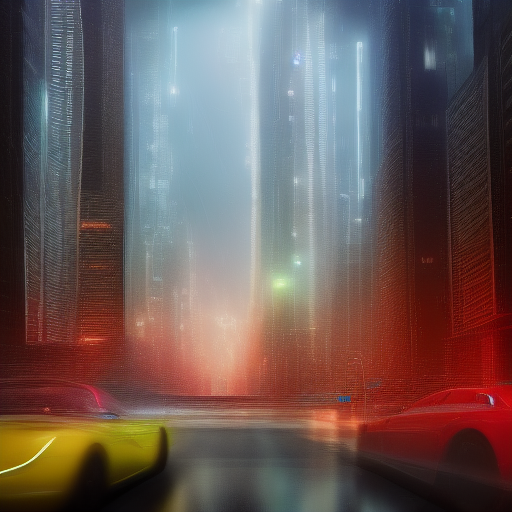

In [ ]:
# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [ ]:
for name, model in models.items():
    print(f"Summary of {name}:")
    print(model)
    print()

Summary of clip:
CLIP(
  (embedding): CLIPEmbedding(
    (token_embedding): Embedding(49408, 768)
  )
  (layers): ModuleList(
    (0-11): 12 x CLIPLayer(
      (layernorm_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention): SelfAttention(
        (in_proj): Linear(in_features=768, out_features=2304, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layernorm_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (linear_1): Linear(in_features=768, out_features=3072, bias=True)
      (linear_2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

Summary of encoder:
VAE_Encoder(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): VAE_ResidualBlock(
    (groupnorm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (g